In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

from mydedalustools import *    
import h5py

%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [ ]:
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

# Earth parameters
R_E = 6.4e6*meter
Omega_E = 2*np.pi/86400 / second
Omega = Omega_E/3  # Omega_E
R     = 80e6*meter # R_E

In [3]:
cp = 1e4 * meter**2 / second**2 / Kelvin
P1 = 0.25**(0.286)
P2 = 0.75**(0.286)

In [89]:
def fill_lon(da):
    lon2 = np.concatenate([da.longitude,[180.]])
    lon2_xr = xr.DataArray(lon2,coords={'longitude':lon2},dims=['longitude'])
    template = (lon2_xr*da[0])**0
    da2 = np.zeros((len(da.longitude)+1,*(da[0].shape)))
    da2[:-1] = da.data
    da2[-1] = da2[0]
    return template*da2

# intro slide

In [80]:
sim_axi = open_h5s_wgauge('snapshots_2level_T21_axi_10_p02_50_p05',('s1','s2')).isel(t=slice(-100,None)).mean('t')
sim_loc = open_h5s_wgauge('snapshots_2levelnew_T21_locked_10_p02_200_p05',('s1','s2')).isel(t=slice(-100,None)).mean('t')




In [46]:
def plot_one_theta_wind_custom(ax,theta,wind,vmin=300,vmax=370,levels=18,cmap = plt.cm.viridis,scale=None,wind_disc=1,include_qk=False,qk_scale=100):
        fill_lon(theta).plot.contourf(ax=ax,y='latitude',levels=levels,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),add_colorbar=False)
        n=2*wind_disc;m=wind_disc
        wind = fill_lon(wind.transpose('longitude','','latitude')).transpose('','longitude','latitude')
        q=ax.quiver(wind.longitude[::n].data,
                  wind.latitude[::m].data ,
                  wind[0][::n,::m].T.data ,
                  -wind[1][::n,::m].T.data,
                  scale=scale,transform=ccrs.PlateCarree())
        ax.set_title('')

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


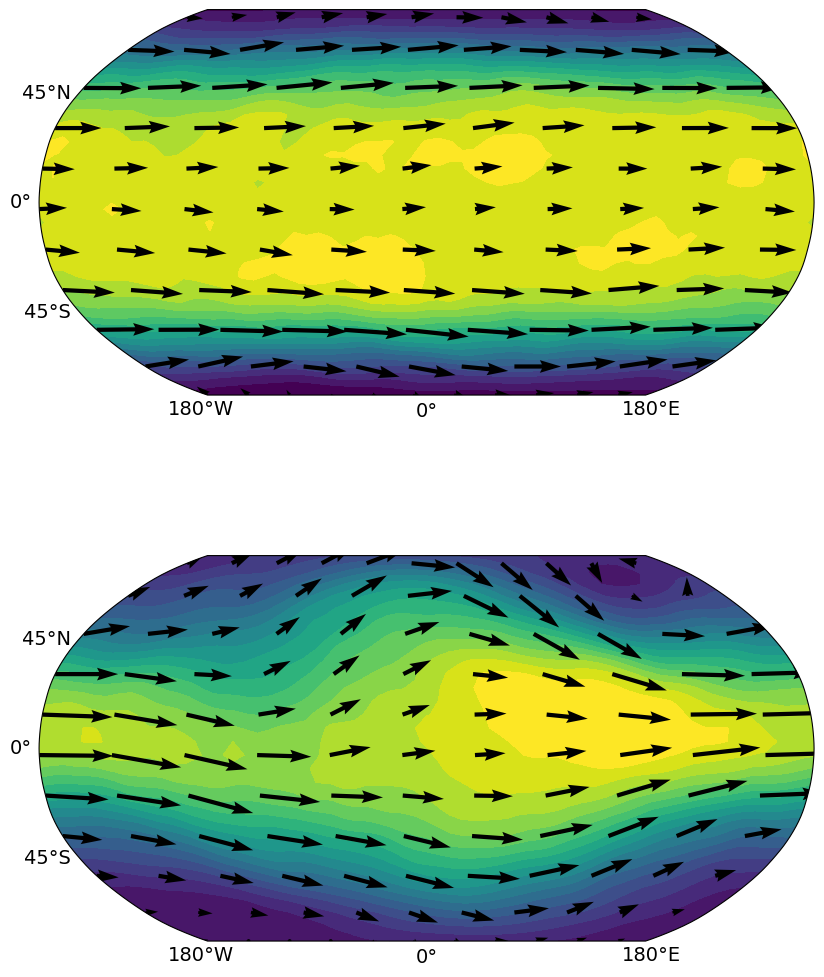

In [81]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,13),subplot_kw={'projection': ccrs.Robinson()})
plot_one_theta_wind_custom(ax1,sim_axi.theta1,sim_axi.u1,None,None,wind_disc=3)
plot_one_theta_wind_custom(ax2,sim_loc.theta1,sim_loc.u1,2300,3050,wind_disc=3)
for a in ax1,ax2:
    a.set_title("")
    a.set_xlabel("")
    a.set_ylabel("")
    
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray',alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(-180,181,180))
    gl.ylocator = mticker.FixedLocator(range(-90,91,45))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

# Earth winds 

In [47]:
u_2019 = xr.open_dataset("/global/cfs/projectdirs/m3310/wboos/era5monthlyQuentin/e5.moda.an.pl/e5.moda.an.pl.128_131_u.ll025uv.2019010100_2019120100.nc")                       
u_2019_zonalmean = u_2019.U.mean(('time','longitude'))                        

In [105]:
u_2018 = xr.open_dataset("/global/cfs/projectdirs/m3310/wboos/era5monthlyQuentin/e5.moda.an.pl/e5.moda.an.pl.128_131_u.ll025uv.2018010100_2018120100.nc")                       
u_2018_zonalmean = u_2018.U.mean(('time','longitude'))                        

In [20]:
import matplotlib

Text(0.5, 1.0, 'Earth zonal wind, 2018')

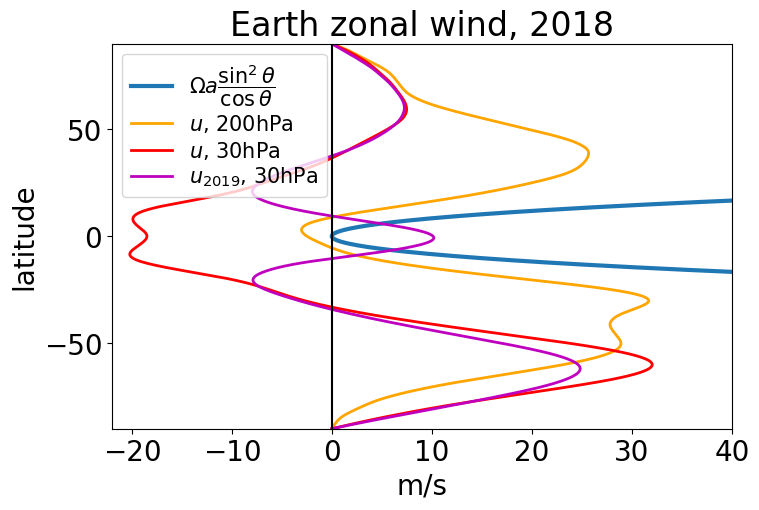

In [115]:
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size':20})
theta = (u_2020.latitude*np.pi/180)
(2*np.pi/86400*6400e3*np.sin(theta)**2/np.cos(theta)).plot(y='latitude',color='C0',linewidth=3,label=r"$\Omega a \dfrac{\sin^2\theta}{\cos\theta}$")
u_2018_zonalmean.sel(level=200).plot(y='latitude',color='orange',linewidth=2,label=r"$u$, 200hPa")
u_2018_zonalmean.sel(level=30).plot(y='latitude',color='r',linewidth=2,label=r"$u$, 30hPa")
u_2019_zonalmean.sel(level=30).plot(y='latitude',color='m',linewidth=2,label=r"$u_{2019}$, 30hPa")


plt.xlim(-22,40)
plt.ylim(-90,90)
plt.axvline(0,color='k')
#plt.axhline(0,color='k')

plt.legend(loc=2,fontsize=15,borderpad=0.4,labelspacing=0.2)
plt.xlabel(r'm/s')
plt.ylabel('latitude')
plt.title('Earth zonal wind, 2018')

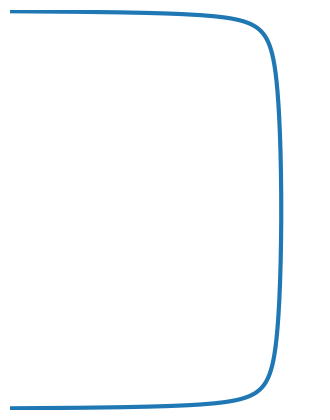

In [125]:
plt.figure(figsize=(4,5.2))
matplotlib.rcParams.update({'font.size':15})
theta = (u_2020.latitude*np.pi/180)
m=0.4
#u_venus = np.tanh((-theta+np.pi/2)/m)*np.tanh((theta+np.pi/2)/m)*(-100)
(-2*np.pi/86400/(243)*6050e3*np.sin(theta)**2/np.cos(theta)).plot(y='latitude',color='C0',linewidth=3,label=r"$\Omega a \dfrac{\sin^2\theta}{\cos\theta}$")
#u_venus.plot(y='latitude',color='orange',linewidth=2,label=r"$u$, 30hPa")
#u_2019_zonalmean.sel(level=30).plot(y='latitude',color='r',linewidth=2,label=r"$u$, 30hPa")


plt.xlim(-140,20)
plt.ylim(-90,90)

#plt.axvline(0,color='k')
#plt.axhline(0,color='k')
plt.axis('off')
#plt.legend(fontsize=13,borderpad=0.4,labelspacing=0.2)
#plt.xlabel(r'm/s')
#plt.ylabel('latitude')
#plt.title('Venus zonal wind (sketch)')
plt.savefig('sketch.png',transparent=True)

# Heating sketches

In [87]:
sim_axi = open_h5s_wgauge('snapshots_2level_T21_axi_10_p02_50_p05',('s1',))


In [152]:
from scipy.integrate import cumtrapz
def ZH_zetaa_u(lat,lat0,alpha):
    f = 2*Omega*np.sin(lat)
    alpha2 = 1/np.cos(lat0)**2-alpha*np.tan(lat0)**2
    dlat = 5*np.pi/180
    step = lambda x: (np.tanh(-x)+1)/2
    zetaa = alpha * f * step((np.abs(lat)-lat0)/dlat) + alpha2 * f * step((-np.abs(lat)+lat0)/dlat)
    u = -cumtrapz(R*(zetaa-f)*np.cos(lat),lat,initial=0)/np.cos(lat)
    return zetaa,u
lat = np.pi/2 - np.linspace(1e-5,np.pi-1e-5,101)
_,u = ZH_zetaa_u(lat,45*np.pi/180,0.)

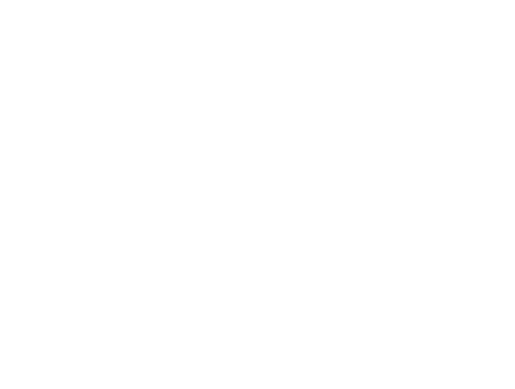

In [157]:
plt.plot(u,lat,color='w',linewidth=5)
plt.axis('off')
plt.savefig('sketch.png',transparent=True)

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


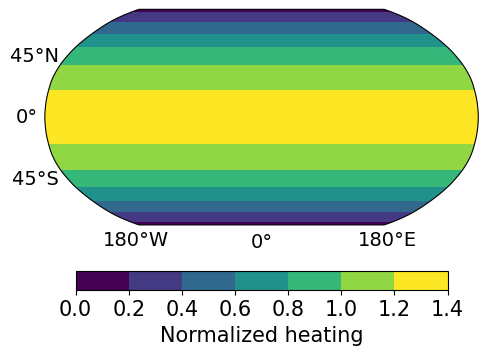

In [161]:
fig, ax = plt.subplots(1,1,figsize=(6,4),subplot_kw={'projection': ccrs.Robinson()})

#lon_forcing = lambda phi: np.pi*np.cos(phi-np.pi)*(np.cos(phi-np.pi)>=0.)
lon_forcing = lambda phi: phi**0
#lon_forcing = lambda phi: 1-0.1*np.cos(phi)
testheating = lon_forcing(sim_axi.phi)*np.sin(sim_axi.theta)*4/np.pi
fill_lon(testheating).plot.contourf(ax=ax,y='latitude',levels=np.arange(0.,1.5,0.2),cmap=plt.cm.viridis,transform=ccrs.PlateCarree(),cbar_kwargs={'label':'Normalized heating','orientation':'horizontal','shrink':0.8})

for a in ax,:
    a.set_title("")
    a.set_xlabel("")
    a.set_ylabel("")
    
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray',alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(-180,181,180))
    gl.ylocator = mticker.FixedLocator(range(-90,91,45))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


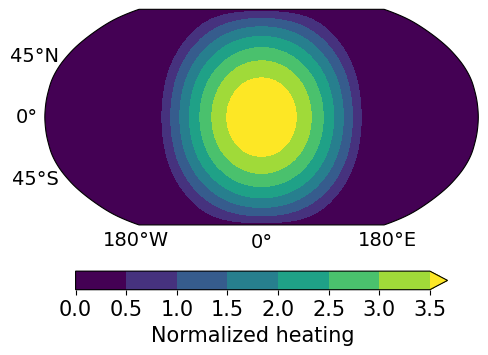

In [162]:
fig, ax = plt.subplots(1,1,figsize=(6,4),subplot_kw={'projection': ccrs.Robinson()})

lon_forcing = lambda phi: np.pi*np.cos(phi-np.pi)*(np.cos(phi-np.pi)>=0.)
#lon_forcing = lambda phi: phi**0
#lon_forcing = lambda phi: 1-0.1*np.cos(phi)
testheating = lon_forcing(sim_axi.phi)*np.sin(sim_axi.theta)*4/np.pi
fill_lon(testheating).plot.contourf(ax=ax,y='latitude',levels=np.arange(0.,4.,0.5),cmap=plt.cm.viridis,transform=ccrs.PlateCarree(),cbar_kwargs={'label':'Normalized heating','orientation':'horizontal','shrink':0.8})

for a in ax,:
    a.set_title("")
    a.set_xlabel("")
    a.set_ylabel("")
    
    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray',alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(-180,181,180))
    gl.ylocator = mticker.FixedLocator(range(-90,91,45))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}